In [33]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.providers.aer import AerSimulator
import qiskit.providers.aer.noise as noise
from datetime import datetime

from qiskit.test.mock import FakeVigo

# Custom Noise Model

In [34]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.05   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [35]:
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits
    


In [36]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

n = 20

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

In [37]:
shots = 8192

il = [0,1,2,3,4]

Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), basis_gates=basis_gates,
                              noise_model = noise_model, shots=shots, initial_layout=il)

In [38]:
result_sim_noise=Trotter_circuit_sim.result()

Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

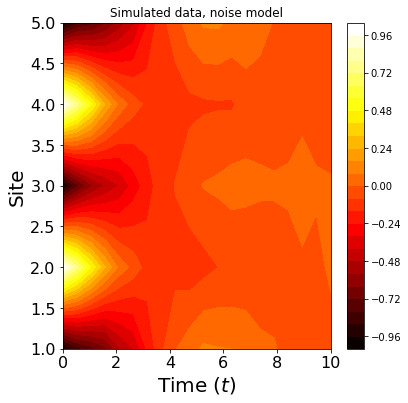

In [39]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Simulated data, noise model')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

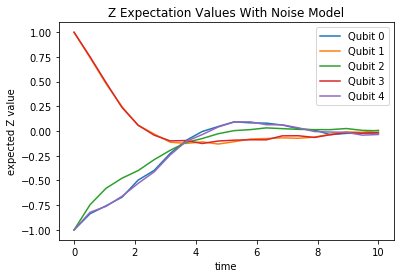

In [40]:
fig,ax = plt.subplots()
ax.plot(t, Sz_sim_noise[:,0], label='Qubit 0')
ax.plot(t, Sz_sim_noise[:,1], label='Qubit 1')
ax.plot(t, Sz_sim_noise[:,2], label='Qubit 2')
ax.plot(t, Sz_sim_noise[:,3], label='Qubit 3')
ax.plot(t, Sz_sim_noise[:,4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values With Noise Model")
ax.legend()

# The Noise Model Minics the Real Device (ibmq_vigo)

In [41]:
device_backend = FakeVigo()

sim_vigo = AerSimulator.from_backend(device_backend) 

#AerSimulator.from_backend : used to create the noise model minics the real device like ibmq_santiago

#device_backend(Input): one can also get noise model minics Santiago backend using code AerSimulator.from_backend(provider.get_backend('ibmq_santiago'))

#sim_vigo (output): one can see it as backend and directly put it on the execute like real device backend.

properties = sim_vigo.properties() # To get info of FakeVigo backend. 

In [42]:
shots = 8192

il = [0,1,2,3,4]

Trotter_circuit_sim = execute(Trotter_circuit, sim_vigo, shots=shots, initial_layout=il) #sim_vigo as the backend

In [43]:
result_sim_noise=Trotter_circuit_sim.result()

Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

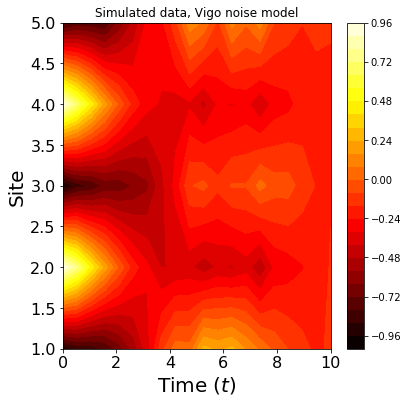

In [44]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Simulated data, Vigo noise model')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

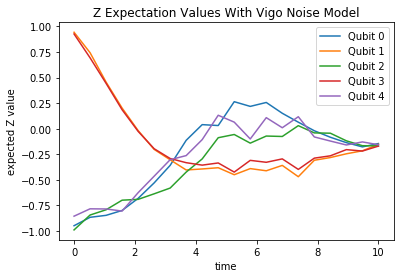

In [45]:
fig,ax = plt.subplots()
ax.plot(t, Sz_sim_noise[:,0], label='Qubit 0')
ax.plot(t, Sz_sim_noise[:,1], label='Qubit 1')
ax.plot(t, Sz_sim_noise[:,2], label='Qubit 2')
ax.plot(t, Sz_sim_noise[:,3], label='Qubit 3')
ax.plot(t, Sz_sim_noise[:,4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values With Vigo Noise Model")
ax.legend()

In [46]:
# Create the text file to record the information of qubits (used for real device, or fake_device like Fake_vigo)
f=open('qubits_info.txt','w')
num_qubits=5
for i in range(num_qubits):
    f.write(str(datetime.now()))
    f.write('\n')
    f.write('qubit_'+str(i)+':')
    print('qubit_'+str(i)+':')
    f.write('\n')
    f.write('T1: '+str(properties.to_dict()['qubits'][i][0]['value'])+' us')
    print('T1: '+str(properties.to_dict()['qubits'][i][0]['value'])+' us')
    f.write('\n')
    f.write('T2: '+str(properties.to_dict()['qubits'][i][1]['value'])+' us')
    print('T2: '+str(properties.to_dict()['qubits'][i][1]['value'])+' us')
    f.write('\n')
    f.write('Frequency: '+str(properties.to_dict()['qubits'][i][2]['value'])+' GHZ')
    print('Frequency: '+str(properties.to_dict()['qubits'][i][2]['value'])+' GHZ')
    f.write('\n')
    f.write('anharmonicity: '+str(properties.to_dict()['qubits'][i][3]['value'])+' GHZ')
    print('anharmonicity: '+str(properties.to_dict()['qubits'][i][3]['value'])+' GHZ')
    f.write('\n')
    f.write('prob_meas0_prep1: '+str(properties.to_dict()['qubits'][i][5]['value']))
    print('prob_meas0_prep1: '+str(properties.to_dict()['qubits'][i][5]['value']))
    f.write('\n')
    f.write('prob_meas1_prep0: '+str(properties.to_dict()['qubits'][i][6]['value']))
    print('prob_meas1_prep0: '+str(properties.to_dict()['qubits'][i][6]['value']))
    f.write('\n')
    f.write('readout_length: '+str(properties.to_dict()['qubits'][i][7]['value'])+' ns')
    print('readout_length: '+str(properties.to_dict()['qubits'][i][7]['value'])+' ns')
    f.write('\n')
f.close()

qubit_0:
T1: 121.70801410836629 us
T2: 17.04998277501956 us
Frequency: 4.796556901072327 GHZ
anharmonicity: -0.3115692205922553 GHZ
prob_meas0_prep1: 0.0736
prob_meas1_prep0: 0.0766
readout_length: 5813.333333333333 ns
qubit_1:
T1: 111.68515230748554 us
T2: 132.02334409889457 us
Frequency: 4.940124055522915 GHZ
anharmonicity: -0.30543161039483363 GHZ
prob_meas0_prep1: 0.03539999999999999
prob_meas1_prep0: 0.0096
readout_length: 5813.333333333333 ns
qubit_2:
T1: 101.82043779287683 us
T2: 68.98073019654157 us
Frequency: 4.8335109735072015 GHZ
anharmonicity: -0.3102935629600691 GHZ
prob_meas0_prep1: 0.0232
prob_meas1_prep0: 0.006
readout_length: 5813.333333333333 ns
qubit_3:
T1: 116.71958434938585 us
T2: 85.88197428799032 us
Frequency: 4.807961451396523 GHZ
anharmonicity: -0.3106927608212116 GHZ
prob_meas0_prep1: 0.027000000000000024
prob_meas1_prep0: 0.016
readout_length: 5813.333333333333 ns
qubit_4:
T1: 86.8005228353819 us
T2: 46.85422114328585 us
Frequency: 4.749674209642721 GHZ
anhar

In [47]:
# Create the text file to record the information of qubits (used for real device, or fake_device like Fake_vigo)
f1=open('gates_info.txt','w')
num_qubits=5
for i in range(num_qubits):
    f1.write(str(datetime.now()))
    f1.write('\n')
    f1.write('qubit_'+str(i)+'gate :')
    print("qubit"+str(i)+' gate :')
    f1.write('\n')
    f1.write('SX_gate error rate '+str(properties.to_dict()['gates'][10+i]['parameters'][0]['value']))
    print('SX_gate error rate '+str(properties.to_dict()['gates'][10+i]['parameters'][0]['value']))
    f1.write('\n')
    f1.write('SX_gate length '+str(properties.to_dict()['gates'][10+i]['parameters'][1]['value'])+' ns')
    print('SX_gate length '+str(properties.to_dict()['gates'][10+i]['parameters'][1]['value'])+' ns')
    f1.write('\n')
    f1.write('X_gate error rate '+str(properties.to_dict()['gates'][15+i]['parameters'][0]['value']))
    print('X_gate error rate '+str(properties.to_dict()['gates'][15+i]['parameters'][0]['value']))
    f1.write('\n')
    f1.write('X_gate length '+str(properties.to_dict()['gates'][15+i]['parameters'][1]['value'])+' ns')
    print('X_gate length '+str(properties.to_dict()['gates'][15+i]['parameters'][1]['value'])+' ns')
    f1.write('\n')
for i in range(2*(num_qubits-1)):
    f1.write('qubit_'+str(properties.to_dict()['gates'][20+i]['qubits'])+' gate :')
    print('qubit_'+str(properties.to_dict()['gates'][20+i]['qubits'])+' gate :')
    f1.write('\n')
    f1.write('Cnot_gate error rate '+str(properties.to_dict()['gates'][20+i]['parameters'][0]['value']))
    print('Cnot_gate error rate '+str(properties.to_dict()['gates'][20+i]['parameters'][0]['value']))
    f1.write('\n')
    f1.write('Cnot_gate length '+str(properties.to_dict()['gates'][20+i]['parameters'][1]['value'])+' ns')
    print('Cnot_gate length '+str(properties.to_dict()['gates'][20+i]['parameters'][1]['value'])+' ns')
f1.close()

qubit0 gate :
SX_gate error rate 0.0004135213478316029
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0004135213478316029
X_gate length 35.55555555555556 ns
qubit1 gate :
SX_gate error rate 0.0005020255558466025
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0005020255558466025
X_gate length 35.55555555555556 ns
qubit2 gate :
SX_gate error rate 0.00040033040197886486
SX_gate length 35.55555555555556 ns
X_gate error rate 0.00040033040197886486
X_gate length 35.55555555555556 ns
qubit3 gate :
SX_gate error rate 0.0006149355812506126
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0006149355812506126
X_gate length 35.55555555555556 ns
qubit4 gate :
SX_gate error rate 0.0006307673923554075
SX_gate length 35.55555555555556 ns
X_gate error rate 0.0006307673923554075
X_gate length 35.55555555555556 ns
qubit_[3, 4] gate :
Cnot_gate error rate 0.00713013415297073
Cnot_gate length 270.22222222222223 ns
qubit_[4, 3] gate :
Cnot_gate error rate 0.00713013415297073
Cnot_ga